# Voting Behavior

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("PREPROCESAMIENTO DE DATOS - VOTING BEHAVIOR")
print("="*80)

PREPROCESAMIENTO DE DATOS - VOTING BEHAVIOR


In [2]:
print("\n[1] CARGANDO DATOS...")

# Cargar el archivo JSON
with open('src/data/raw/Voting_behavior.json', 'r') as f:
    data = json.load(f)

# Convertir a DataFrame
df = pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])
print(f"✓ Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")


[1] CARGANDO DATOS...
✓ Datos cargados: 1000 filas, 17 columnas


In [3]:
print("\n[2] EXPLORACIÓN INICIAL")
print("-" * 80)

print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación general:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores únicos por columna:")
for col in df.columns:
    print(f"  {col}: {df[col].nunique()} valores únicos")


[2] EXPLORACIÓN INICIAL
--------------------------------------------------------------------------------

Primeras 5 filas:
      county_name state_code  fips_code  election_year  total_population  \
0         Atlanta    Georgia          1           2010           7767889   
1           Flint   Michigan          2           2010           8229997   
2         Norfolk   Virginia          3           1991            639164   
3  Salt Lake City       Utah          4           1984           2868470   
4        Anniston    Alabama          5           2013           1570096   

   median_age  median_household_income  pct_bachelors_or_higher  \
0        43.0                    50385                    30.99   
1        22.7                   102777                    42.81   
2        47.5                    29737                    77.87   
3        68.5                    44024                    52.62   
4        32.5                   105090                    47.82   

   total_regist

In [4]:
print("\n[3] IDENTIFICACIÓN DE PROBLEMAS")
print("-" * 80)

# 3.1 Valores nulos
print("\n3.1 Valores Nulos:")
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_summary = pd.DataFrame({
    'Nulos': null_counts,
    'Porcentaje': null_pct
})
print(null_summary[null_summary['Nulos'] > 0])

# 3.2 Valores duplicados
print("\n3.2 Valores Duplicados:")
duplicates = df.duplicated().sum()
print(f"  Filas duplicadas completas: {duplicates}")
if duplicates > 0:
    print("  Mostrando duplicados:")
    print(df[df.duplicated(keep=False)])

# 3.3 Inconsistencias en códigos geográficos
print("\n3.3 Inconsistencias Geográficas:")

# Verificar formato de state_code (debería ser XX-XX o similar)
if 'state_code' in df.columns:
    invalid_state_codes = df[~df['state_code'].str.match(r'^[A-Z]{2}-[A-Z]{2}$', na=False)]
    print(f"  State codes con formato inválido: {len(invalid_state_codes)}")
    if len(invalid_state_codes) > 0:
        print(invalid_state_codes[['county_name', 'state_code']].head())

# Verificar FIPS codes (deberían ser numéricos positivos)
if 'fips_code' in df.columns:
    invalid_fips = df[(df['fips_code'] <= 0) | (df['fips_code'].isnull())]
    print(f"  FIPS codes inválidos: {len(invalid_fips)}")

# 3.4 Inconsistencias en votación
print("\n3.4 Inconsistencias en Datos de Votación:")

# Verificar que votos totales no excedan ballots cast
df['calculated_total_votes'] = df['democrat_votes'].fillna(0) + \
                                df['republican_votes'].fillna(0) + \
                                df['other_votes'].fillna(0)

votes_exceed_ballots = df[df['calculated_total_votes'] > df['total_ballots_cast']]
print(f"  Registros donde votos totales > ballots cast: {len(votes_exceed_ballots)}")

# Verificar que ballots cast no excedan voters registrados
ballots_exceed_voters = df[df['total_ballots_cast'] > df['total_registered_voters']]
print(f"  Registros donde ballots cast > registered voters: {len(ballots_exceed_voters)}")

# Verificar que registered voters no excedan población total
voters_exceed_pop = df[df['total_registered_voters'] > df['total_population']]
print(f"  Registros donde registered voters > población: {len(voters_exceed_pop)}")

# 3.5 Inconsistencias en porcentajes demográficos
print("\n3.5 Inconsistencias Demográficas:")

# Los porcentajes raciales pueden solaparse, pero verifiquemos valores razonables
pct_cols = ['pct_white', 'pct_black', 'pct_hispanic', 'pct_asian']
df['total_pct_race'] = df[pct_cols].sum(axis=1)

# Porcentajes negativos
negative_pct = df[(df[pct_cols] < 0).any(axis=1)]
print(f"  Registros con porcentajes negativos: {len(negative_pct)}")

# Porcentajes mayores a 100
over_100_pct = df[(df[pct_cols] > 100).any(axis=1)]
print(f"  Registros con porcentajes > 100: {len(over_100_pct)}")

# Suma de porcentajes muy diferente de 100 (considerando solapamiento)
unusual_total = df[(df['total_pct_race'] < 80) | (df['total_pct_race'] > 150)]
print(f"  Registros con suma racial inusual (<80 o >150): {len(unusual_total)}")

# 3.6 Valores atípicos (outliers)
print("\n3.6 Valores Atípicos Detectados:")

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)]
    if len(outliers) > 0:
        print(f"  {col}: {len(outliers)} outliers extremos")


[3] IDENTIFICACIÓN DE PROBLEMAS
--------------------------------------------------------------------------------

3.1 Valores Nulos:
Empty DataFrame
Columns: [Nulos, Porcentaje]
Index: []

3.2 Valores Duplicados:
  Filas duplicadas completas: 0

3.3 Inconsistencias Geográficas:
  State codes con formato inválido: 1000
      county_name state_code
0         Atlanta    Georgia
1           Flint   Michigan
2         Norfolk   Virginia
3  Salt Lake City       Utah
4        Anniston    Alabama
  FIPS codes inválidos: 0

3.4 Inconsistencias en Datos de Votación:
  Registros donde votos totales > ballots cast: 524
  Registros donde ballots cast > registered voters: 544
  Registros donde registered voters > población: 364

3.5 Inconsistencias Demográficas:
  Registros con porcentajes negativos: 0
  Registros con porcentajes > 100: 0
  Registros con suma racial inusual (<80 o >150): 701

3.6 Valores Atípicos Detectados:
  election_year: 2 outliers extremos


In [5]:
print("\n[4] LIMPIEZA Y CORRECCIÓN DE DATOS")
print("-" * 80)

df_clean = df.copy()

# 4.1 Manejo de valores nulos
print("\n4.1 Tratamiento de Valores Nulos:")

# other_votes: Si es null, asumimos 0
if 'other_votes' in df_clean.columns:
    null_other = df_clean['other_votes'].isnull().sum()
    df_clean['other_votes'] = df_clean['other_votes'].fillna(0)
    print(f"  ✓ Reemplazados {null_other} nulos en 'other_votes' con 0")

# Para otros campos numéricos críticos, marcar para revisión
critical_cols = ['total_population', 'total_registered_voters', 'total_ballots_cast']
for col in critical_cols:
    if col in df_clean.columns:
        null_count = df_clean[col].isnull().sum()
        if null_count > 0:
            print(f"  ⚠ {col}: {null_count} valores nulos - REQUIERE REVISIÓN MANUAL")

# 4.2 Corrección de inconsistencias en votación
print("\n4.2 Corrección de Inconsistencias en Votación:")

# Recalcular votos totales
df_clean['total_votes_calculated'] = (df_clean['democrat_votes'].fillna(0) + 
                                      df_clean['republican_votes'].fillna(0) + 
                                      df_clean['other_votes'].fillna(0))

# Flaggear registros problemáticos
df_clean['flag_votes_exceed_ballots'] = df_clean['total_votes_calculated'] > df_clean['total_ballots_cast']
df_clean['flag_ballots_exceed_voters'] = df_clean['total_ballots_cast'] > df_clean['total_registered_voters']
df_clean['flag_voters_exceed_population'] = df_clean['total_registered_voters'] > df_clean['total_population']

flagged = df_clean[['flag_votes_exceed_ballots', 'flag_ballots_exceed_voters', 
                    'flag_voters_exceed_population']].sum()
print(f"  ✓ Registros flaggeados para revisión:")
for flag, count in flagged.items():
    if count > 0:
        print(f"    - {flag}: {count}")

# 4.3 Validación de porcentajes
print("\n4.3 Validación de Porcentajes:")

# Asegurar que porcentajes estén entre 0 y 100
pct_columns = ['pct_white', 'pct_black', 'pct_hispanic', 'pct_asian', 'pct_bachelors_or_higher']
for col in pct_columns:
    if col in df_clean.columns:
        # Clip valores fuera de rango
        before = len(df_clean[(df_clean[col] < 0) | (df_clean[col] > 100)])
        df_clean[col] = df_clean[col].clip(0, 100)
        if before > 0:
            print(f"  ✓ Corregidos {before} valores fuera de rango en '{col}'")

# 4.4 Crear variables derivadas útiles
print("\n4.4 Creación de Variables Derivadas:")

# Turnout rate (participación electoral)
df_clean['turnout_rate'] = (df_clean['total_ballots_cast'] / 
                            df_clean['total_registered_voters'] * 100).clip(0, 150)
print("  ✓ Creada 'turnout_rate'")

# Registration rate
df_clean['registration_rate'] = (df_clean['total_registered_voters'] / 
                                 df_clean['total_population'] * 100).clip(0, 100)
print("  ✓ Creada 'registration_rate'")

# Porcentajes de votos por partido
df_clean['pct_democrat'] = (df_clean['democrat_votes'] / 
                            df_clean['total_votes_calculated'] * 100).fillna(0)
df_clean['pct_republican'] = (df_clean['republican_votes'] / 
                              df_clean['total_votes_calculated'] * 100).fillna(0)
df_clean['pct_other'] = (df_clean['other_votes'] / 
                         df_clean['total_votes_calculated'] * 100).fillna(0)
print("  ✓ Creados porcentajes de voto por partido")

# Margin of victory
df_clean['vote_margin'] = abs(df_clean['democrat_votes'] - df_clean['republican_votes'])
df_clean['winning_party'] = df_clean.apply(
    lambda x: 'Democrat' if x['democrat_votes'] > x['republican_votes'] 
    else ('Republican' if x['republican_votes'] > x['democrat_votes'] else 'Tie'),
    axis=1
)
print("  ✓ Creadas 'vote_margin' y 'winning_party'")

# 4.5 Normalización de datos textuales
print("\n4.5 Normalización de Datos Textuales:")

if 'county_name' in df_clean.columns:
    df_clean['county_name'] = df_clean['county_name'].str.strip().str.title()
    print("  ✓ Normalizado 'county_name'")

if 'state_code' in df_clean.columns:
    df_clean['state_code'] = df_clean['state_code'].str.upper().str.strip()
    print("  ✓ Normalizado 'state_code'")


[4] LIMPIEZA Y CORRECCIÓN DE DATOS
--------------------------------------------------------------------------------

4.1 Tratamiento de Valores Nulos:
  ✓ Reemplazados 0 nulos en 'other_votes' con 0

4.2 Corrección de Inconsistencias en Votación:
  ✓ Registros flaggeados para revisión:
    - flag_votes_exceed_ballots: 524
    - flag_ballots_exceed_voters: 544
    - flag_voters_exceed_population: 364

4.3 Validación de Porcentajes:

4.4 Creación de Variables Derivadas:
  ✓ Creada 'turnout_rate'
  ✓ Creada 'registration_rate'
  ✓ Creados porcentajes de voto por partido
  ✓ Creadas 'vote_margin' y 'winning_party'

4.5 Normalización de Datos Textuales:
  ✓ Normalizado 'county_name'
  ✓ Normalizado 'state_code'


In [6]:
print("\n[5] VALIDACIÓN FINAL")
print("-" * 80)

print(f"\nDimensiones finales: {df_clean.shape[0]} filas, {df_clean.shape[1]} columnas")

print("\nColumnas con flags de calidad:")
flag_cols = [col for col in df_clean.columns if col.startswith('flag_')]
for col in flag_cols:
    count = df_clean[col].sum()
    print(f"  {col}: {count} registros")

print("\nResumen de calidad de datos:")
completeness = (1 - df_clean.isnull().sum() / len(df_clean)) * 100
quality_summary = pd.DataFrame({
    'Completitud (%)': completeness.round(2)
}).sort_values('Completitud (%)')
print(quality_summary)


[5] VALIDACIÓN FINAL
--------------------------------------------------------------------------------

Dimensiones finales: 1000 filas, 30 columnas

Columnas con flags de calidad:
  flag_votes_exceed_ballots: 524 registros
  flag_ballots_exceed_voters: 544 registros
  flag_voters_exceed_population: 364 registros

Resumen de calidad de datos:
                               Completitud (%)
county_name                              100.0
state_code                               100.0
fips_code                                100.0
election_year                            100.0
total_population                         100.0
median_age                               100.0
median_household_income                  100.0
pct_bachelors_or_higher                  100.0
total_registered_voters                  100.0
total_ballots_cast                       100.0
democrat_votes                           100.0
republican_votes                         100.0
other_votes                              100

In [7]:
print("\n[6] EXPORTACIÓN DE DATOS")
print("-" * 80)

# Guardar versión limpia
output_path = 'src/data/processed/Voting_behavior.csv'
df_clean.to_csv(output_path, index=False)
print(f"✓ Datos limpios guardados en: {output_path}")

# Guardar reporte de problemas
problems_df = df_clean[df_clean[flag_cols].any(axis=1)] if flag_cols else pd.DataFrame()
# if len(problems_df) > 0:
#     problems_path = 'src/data/processed/Voting_behavior_problems.csv'
#     problems_df.to_csv(problems_path, index=False)
#     print(f"✓ Registros problemáticos guardados en: {problems_path}")

# Crear reporte de limpieza
report = {
    'Fecha de procesamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Registros originales': len(df),
    'Registros finales': len(df_clean),
    'Registros eliminados': len(df) - len(df_clean),
    'Columnas originales': len(df.columns),
    'Columnas finales': len(df_clean.columns),
    'Registros con problemas': len(problems_df) if len(problems_df) > 0 else 0
}

print("\n" + "="*80)
print("REPORTE DE LIMPIEZA COMPLETADO")
print("="*80)
for key, value in report.items():
    print(f"{key}: {value}")

# Mostrar muestra de datos limpios
print("\nMuestra de datos limpios (primeras 3 filas):")
display_cols = ['county_name', 'state_code', 'election_year', 'total_population', 
                'turnout_rate', 'winning_party', 'pct_democrat', 'pct_republican']
available_cols = [col for col in display_cols if col in df_clean.columns]
print(df_clean[available_cols].head(3))

print("\n✓ PREPROCESAMIENTO COMPLETADO - Datos listos")
print("="*80)


[6] EXPORTACIÓN DE DATOS
--------------------------------------------------------------------------------
✓ Datos limpios guardados en: src/data/processed/Voting_behavior.csv

REPORTE DE LIMPIEZA COMPLETADO
Fecha de procesamiento: 2025-11-03 08:12:07
Registros originales: 1000
Registros finales: 1000
Registros eliminados: 0
Columnas originales: 19
Columnas finales: 30
Registros con problemas: 951

Muestra de datos limpios (primeras 3 filas):
  county_name state_code  election_year  total_population  turnout_rate  \
0     Atlanta    GEORGIA           2010           7767889    150.000000   
1       Flint   MICHIGAN           2010           8229997    129.624711   
2     Norfolk   VIRGINIA           1991            639164    150.000000   

  winning_party  pct_democrat  pct_republican  
0    Republican     26.768285       71.969757  
1    Republican     16.388613       83.053843  
2    Republican     23.262302       75.351687  

✓ PREPROCESAMIENTO COMPLETADO - Datos listos


In [8]:
print("="*80)
print("ANALYSIS - VOTING BEHAVIOR")
print("="*80)

# Cargar datos
df = pd.read_csv('src/data/processed/Voting_behavior.csv')

print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nAvailable columns:")
print(df.columns.tolist())

df[['turnout_rate', 'pct_bachelors_or_higher', 'median_age', 'pct_hispanic',
    'pct_democrat', 'pct_republican']].corr()


ANALYSIS - VOTING BEHAVIOR
Rows: 1000, Columns: 30

Available columns:
['county_name', 'state_code', 'fips_code', 'election_year', 'total_population', 'median_age', 'median_household_income', 'pct_bachelors_or_higher', 'total_registered_voters', 'total_ballots_cast', 'democrat_votes', 'republican_votes', 'other_votes', 'pct_white', 'pct_black', 'pct_hispanic', 'pct_asian', 'calculated_total_votes', 'total_pct_race', 'total_votes_calculated', 'flag_votes_exceed_ballots', 'flag_ballots_exceed_voters', 'flag_voters_exceed_population', 'turnout_rate', 'registration_rate', 'pct_democrat', 'pct_republican', 'pct_other', 'vote_margin', 'winning_party']


,turnout_rate,pct_bachelors_or_higher,median_age,pct_hispanic,pct_democrat,pct_republican
turnout_rate,1.000000,-0.008078,-0.049861,0.008983,0.037435,-0.035786
pct_bachelors_or_higher,-0.008078,1.000000,-0.039157,0.021337,-0.027243,0.026447
median_age,-0.049861,-0.039157,1.000000,-0.005459,0.000736,0.001916
pct_hispanic,0.008983,0.021337,-0.005459,1.000000,-0.006080,0.002581
pct_democrat,0.037435,-0.027243,0.000736,-0.006080,1.000000,-0.994905
pct_republican,-0.035786,0.026447,0.001916,0.002581,-0.994905,1.000000


 ---
 ## 🧩 Hypothesis 1

 **Hypothesis:**  
 > “Counties with higher educational attainment show higher voter turnout.”

 **Rationale:**  
 Higher education levels are often linked to greater civic engagement, 
 which may translate into higher participation rates in elections.

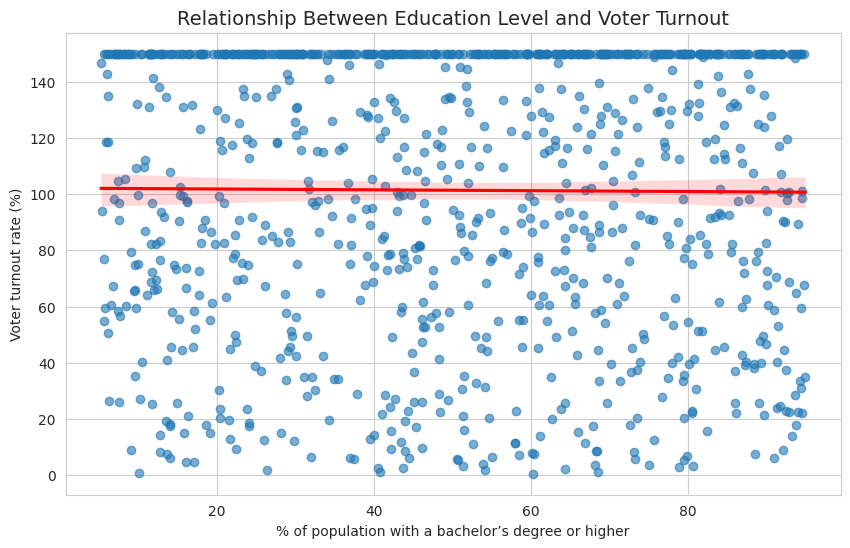

In [9]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='pct_bachelors_or_higher', y='turnout_rate',
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Relationship Between Education Level and Voter Turnout', fontsize=14)
plt.xlabel('% of population with a bachelor’s degree or higher')
plt.ylabel('Voter turnout rate (%)')
plt.show()

 ---
 ## 🧩 Hypothesis 2

 **Hypothesis:**  
 > “Counties with older populations tend to have a higher share of Republican votes.”

 **Rationale:**  
 In many political contexts, age is associated with more conservative voting patterns.  
 We’ll examine whether higher `median_age` correlates with a higher `pct_republican`.

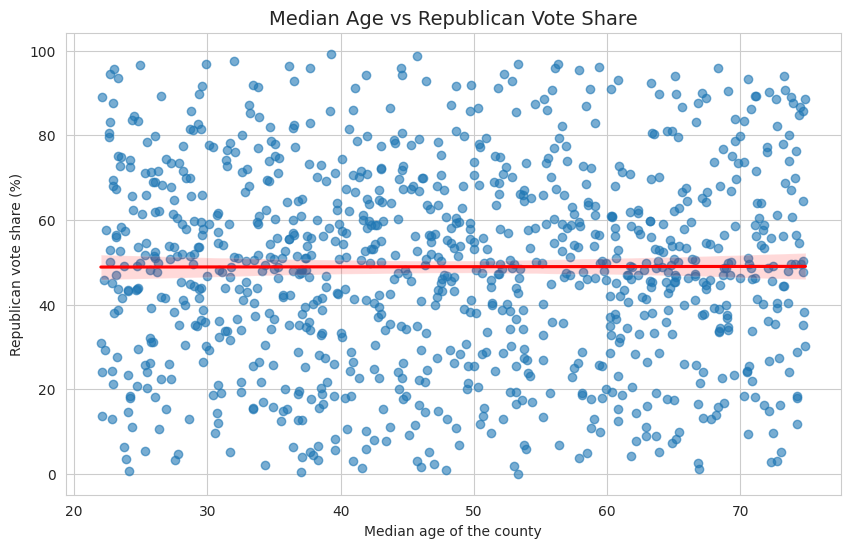

In [10]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='median_age', y='pct_republican',
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Median Age vs Republican Vote Share', fontsize=14)
plt.xlabel('Median age of the county')
plt.ylabel('Republican vote share (%)')
plt.show()

 ---
 ## 🧩 Hypothesis 3

 **Hypothesis:**  
 > “Counties with a higher proportion of Hispanic population tend to vote more for the Democratic Party.”

 **Rationale:**  
 Prior demographic studies suggest that Hispanic populations tend to support the Democratic Party.  
 We’ll test whether a higher `pct_hispanic` is associated with a higher `pct_democrat`.

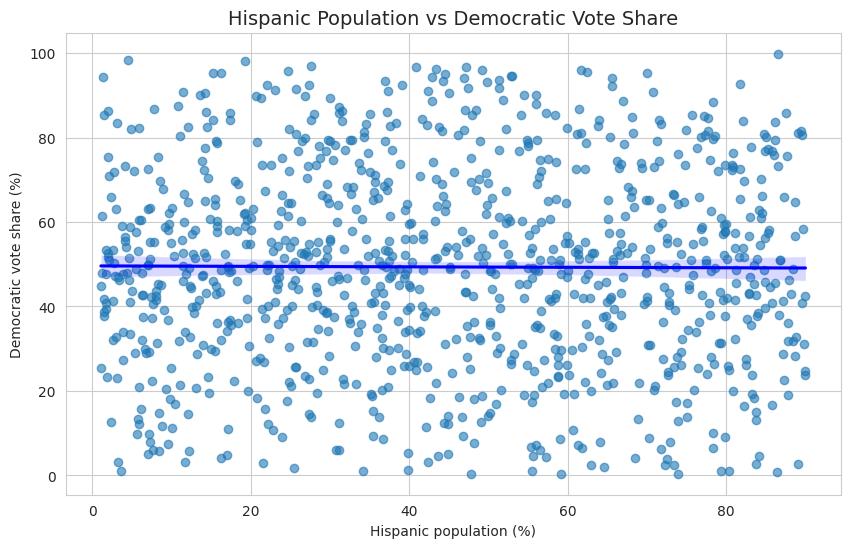

In [11]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='pct_hispanic', y='pct_democrat',
            scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
plt.title('Hispanic Population vs Democratic Vote Share', fontsize=14)
plt.xlabel('Hispanic population (%)')
plt.ylabel('Democratic vote share (%)')
plt.show()